In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [2]:
polarities = pd.read_csv("./polarities.csv").dropna()
polarities.head()

,Unnamed: 0,tweet_id,tweet_text,user/name,user_id,n_tweets,flagged,pol_rightness,credibility,moderacy
0,0,1346674133111865347,The steal is in the making in Georgia. Wait fo...,TomiLahren,1276954908848197633,198,True,0.46,2.00,1.80
1,1,1346674133111865347,The steal is in the making in Georgia. Wait fo...,TomiLahren,1333031903725686785,3101,True,-0.31,2.00,1.93
2,2,1346674133111865347,The steal is in the making in Georgia. Wait fo...,TomiLahren,984139126558539776,2743,True,-0.16,2.01,1.83
3,3,1346674133111865347,The steal is in the making in Georgia. Wait fo...,TomiLahren,888424614732353536,1231,True,0.50,2.04,1.99
4,4,1346674133111865347,The steal is in the making in Georgia. Wait fo...,TomiLahren,1034539618472013825,2628,True,0.11,2.01,1.64


In [3]:
polarities['user/name'].unique()

array(['TomiLahren', 'EricTrump', 'AdamLaxalt', 'DonaldJTrumpJr',
       'MariaBartiromo', 'RudyGiuliani', 'Paduch'], dtype=object)

In [4]:
polarities.shape

(669, 10)

In [5]:
polarities['flagged'].value_counts()

True     343
False    326
Name: flagged, dtype: int64

### Exploratory Analysis

In [27]:
data = polarities[['flagged', 'pol_rightness', 'credibility', 'moderacy']]
data.columns = ['Flagged', 'Political', 'Credibility', 'Moderacy']
data.describe()

,Political,Credibility,Moderacy
count,669.000000,669.000000,669.000000
mean,-0.093797,2.011286,1.872422
std,0.501687,0.019959,0.195158
min,-1.160000,1.990000,1.140000
25%,-0.430000,2.000000,1.810000
50%,-0.170000,2.000000,1.910000
75%,0.110000,2.010000,1.950000
max,2.730000,2.150000,2.820000


In [28]:
data.head()

,Flagged,Political,Credibility,Moderacy
0,True,0.46,2.00,1.80
1,True,-0.31,2.00,1.93
2,True,-0.16,2.01,1.83
3,True,0.50,2.04,1.99
4,True,0.11,2.01,1.64


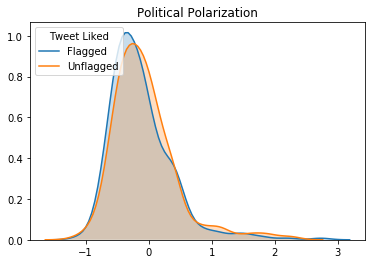

In [29]:
pol_flagged = data[data['Flagged']]['Political']
pol_unflagged = data[data['Flagged'] == False]['Political']
sns.kdeplot(pol_flagged, shade=True).set_title("Political Polarization")
sns.kdeplot(pol_unflagged, shade=True)
plt.legend(title='Tweet Liked', loc='upper left', labels=['Flagged', 'Unflagged'])
plt.savefig("political_kde.png")

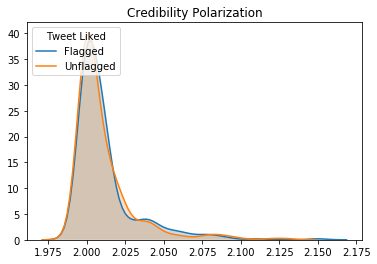

In [30]:
pol_flagged = data[data['Flagged']]['Credibility']
pol_unflagged = data[data['Flagged'] == False]['Credibility']
sns.kdeplot(pol_flagged, shade=True).set_title("Credibility Polarization")
sns.kdeplot(pol_unflagged, shade=True)
plt.legend(title='Tweet Liked', loc='upper left', labels=['Flagged', 'Unflagged'])

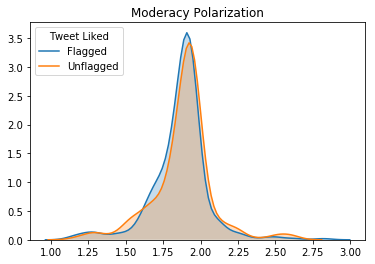

In [31]:
pol_flagged = data[data['Flagged']]['Moderacy']
pol_unflagged = data[data['Flagged'] == False]['Moderacy']
sns.kdeplot(pol_flagged, shade=True).set_title("Moderacy Polarization")
sns.kdeplot(pol_unflagged, shade=True)
plt.legend(title='Tweet Liked', loc='upper left', labels=['Flagged', 'Unflagged'])

### Examining Correlation  
This section looks at whether there is a quantifiable and/or visual correlation between each of the three dimensions. Each of the below plots is made up of points, each one representing a user. The color of the point indicates whether that user was one who retweeted a flagged tweet or an unflagged tweet.

**Political vs Credibility**

Text(0.5,1,'User Political verus Credibility Polarity')

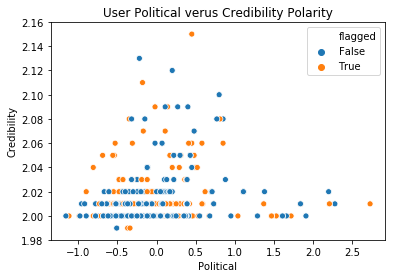

In [32]:
sub_data = data[['Political', 'Credibility']]
sns.scatterplot(x=sub_data['Political'], y=sub_data['Credibility'],
                hue=polarities['flagged']).set_title("User Political verus Credibility Polarity")

In [37]:
print("Correlation Matrix")
print(sub_data.corr())

Correlation Matrix
           Political  Moderacy
Political   1.000000  0.242497
Moderacy    0.242497  1.000000


**Political vs Moderacy**

Text(0.5,1,'User Political vs Moderacy Polarity')

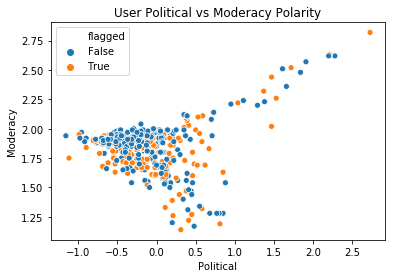

In [34]:
sub_data = data[['Political', 'Moderacy']]
sns.scatterplot(x=sub_data['Political'], y=sub_data['Moderacy'],
                hue=polarities['flagged']).set_title("User Political vs Moderacy Polarity")

In [36]:
print("Correlation Matrix")
print(sub_data.corr())

Correlation Matrix
           Political  Moderacy
Political   1.000000  0.242497
Moderacy    0.242497  1.000000


**Moderacy vs Credibility**

Text(0.5,1,'User Credibility verus Moderacy Polarity')

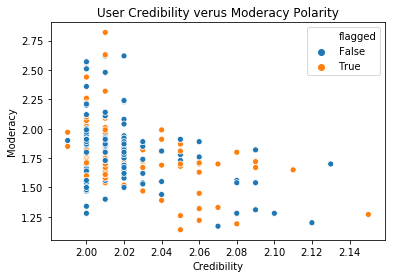

In [39]:
sub_data = data[['Moderacy', 'Credibility']]
sns.scatterplot(x=sub_data['Credibility'], y=sub_data['Moderacy'],
                hue=polarities['flagged']).set_title("User Credibility verus Moderacy Polarity")

In [40]:
print("Correlation Matrix")
print(sub_data.corr())

Correlation Matrix
             Moderacy  Credibility
Moderacy     1.000000    -0.502355
Credibility -0.502355     1.000000


### Test 1
I will perform a permutation test for each dimension. That is, for one dimension I will calculate the difference between the sample means for all polarity scores for the flagged tweets group and then for the unflagged tweets groups. I will define the test statistic as the difference between those two means. I will then shuffle the flagged/unflagged labels and then recalculate the statistic. I will do this 100 times then calculate the p value.  
  
**Permutation Test:**  
  
Test Statistic: Define the test statistic as the difference between the sample means for the flagged and unflagged group for one dimension  
  
Null Hypothesis: There is no difference in the polarity scores distribution between the flagged and unflagged groups  
  
Alternative Hypothesis: The flagged users have a lower polarity score in a respective dimension than the unflagged users  
  
Reject null if p value < .1

In [47]:
# Defining functions for use in permutation test
def abs_mean_diff(data, dim):
    return (np.mean(data[data['flagged'] == True][dim]) - np.mean(data[data['flagged'] == False][dim]))

def permutation_test(data, n_reps, dim):
    # Observed statistic
    obs = abs_mean_diff(data, dim)
    
    # Running and permuting n_reps of the data
    trials = []
    for i in range(n_reps):
        shuffled_impres = (
            data['flagged']
            .sample(replace=False, frac=1)
            .reset_index(drop=True)
        )
        shuffled = (
            data
            .assign(**{'flagged': shuffled_impres})
        )
        trials.append(abs_mean_diff(shuffled, dim))
    return np.count_nonzero(np.array(trials) <= obs) / n_reps, trials, obs

{'Dimension': 'pol_rightness', 'p-value': 0.065}


{'Dimension': 'credibility', 'p-value': 0.662}


{'Dimension': 'moderacy', 'p-value': 0.116}




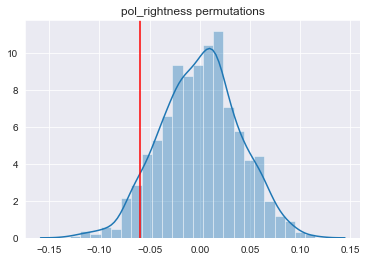

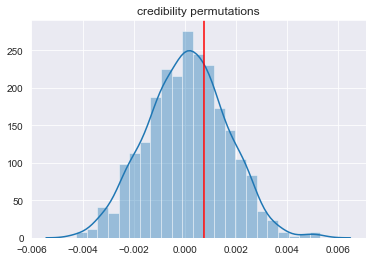

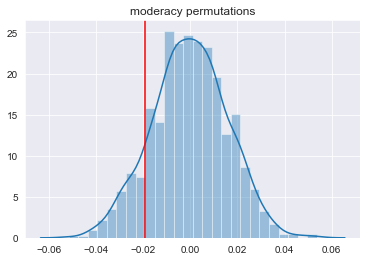

In [61]:
# First let's run the test for the political polarity
data = polarities[['pol_rightness', 'credibility', 'moderacy', 'flagged']]
outcomes = []
dimensions = ['pol_rightness', 'credibility', 'moderacy']
for i, dim in enumerate(dimensions):
    p_value, trials, obs = permutation_test(data, 1000, dim)
    out = {'Dimension': dim, 
           'p-value': p_value}
    plt.figure(i)
    sns.set_style("darkgrid")
    sns.distplot(trials).set_title(dim + " permutations")
    plt.axvline(obs, 0, 30, color="r")
    outcomes.append(out)
    print(out)
    print("\n")
with open('./test.json', 'w') as fout:
    json.dump(outcomes , fout)

In [54]:
obs

-0.019148884794934817

**Evaluating:**  
1. For the political dimension, we have sufficient evidence to reject the null hypothesis and the data supports that the group of users who retweeted flagged tweets have a more left leaning political score than the users who retweeted the unflagged tweets.  
2. For the credibility dimension we do not have sufficient evidence to reject the null hypothesis. The two groups display similar levels of credibility for their preferences.  
3. For the moderacy dimension we are able to reject the null hypothesis and the data supports that the group of users who retweeted the flagged tweets have a more moderate polarity score than the users who retweeted the unflagged tweets.

### Test 2
We will compare the data for each dimension using a t-test. Under this test we assume the data is normally distributed with the same variance. We will perform a two-sided test between the flagged and unflagged group for each dimension.  
  
**Two-sided t-test**  

In [63]:
outcomes = []
for dim in dimensions:
    flagged = data[data['flagged'] == True][dim]
    unflagged = data[data['flagged'] == False][dim]
    out = {'Dimension': dim, 
           'Results': stats.ttest_ind(flagged, unflagged, equal_var=True)}
    outcomes.append(out)
outcomes

[{'Dimension': 'pol_rightness',
  'Results': Ttest_indResult(statistic=-1.5445782390461946, pvalue=0.12292260950534312)},
 {'Dimension': 'credibility',
  'Results': Ttest_indResult(statistic=0.4999421704837653, pvalue=0.6172806854906729)},
 {'Dimension': 'moderacy',
  'Results': Ttest_indResult(statistic=-1.2691073275979001, pvalue=0.2048454575958873)}]

**Outcome** 
We can see a very similar outcome as the permutation test, as we would expect. Next we will test the one-sided t-test for both groups

### Test 3
We will test whether flagged group has statistically significantly higher or lower polarity scores than the unflagged group for both dimensions. We will use a one-sided t-test.  
**One-sided t-test**

In [62]:
outcomes = []
for dim in dimensions:
    flagged = data[data['flagged'] == True][dim]
    unflagged = data[data['flagged'] == False][dim]
    gen = stats.ttest_ind(flagged, unflagged, equal_var=True)
    out = {'Dimension': dim,
           'p-value': gen[1]/2,
           'Test Statistic': gen[0]
          }
    print(out)
    print("\n")
    outcomes.append(out)

{'Dimension': 'pol_rightness', 'p-value': 0.06146130475267156, 'Test Statistic': -1.5445782390461946}


{'Dimension': 'credibility', 'p-value': 0.30864034274533647, 'Test Statistic': 0.4999421704837653}


{'Dimension': 'moderacy', 'p-value': 0.10242272879794365, 'Test Statistic': -1.2691073275979001}




**Outcome**  
 